# Whatsapp Group Analysis

We can export whatsapp group chat and we get data in below formate.

30/04/18, 1:21 pm - +91 96191 49854: 😂😂😂

08/05/18, 5:56 pm - Sam: RCB kal hi hara hai

In our sample line of text as above, we want to clean data as below format.

{Date}, {Time} - {Author}: {Message}

{08/05/18}, {5:56 pm} - {Sam}: {RCB kal hi hara hai}

In [1]:
# List of libraries need to install

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import regex
import emoji
import plotly.express as px
from collections import Counter
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Data Preparation

In [2]:
# Code to check if new line start with date and time

def date_and_time_check(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [3]:
date_and_time_check('08/05/18, 5:56 pm - Sam: RCB kal hi hara hai')

True

In [4]:
def author_finder(s):
    s = s.split(': ')
    if len(s) > 1:    # return True is more than 1 entry found
        return True
    return False

In [5]:
author_finder('08/05/18, 5:56 pm - Sam: RCB kal hi hara hai')

True

In [6]:
# Code to change the time format from 12hrs to 24 hrs
def time_formater(s): 

    if s[-2:] == "am" and s[:2] == "12": 
        return "00" + s[2:-3]     
    elif s[-2:] == "am": 
        return s[:-3] 
    elif s[-2:] == "pm" and s[:2] == "12": 
        return s[:-3]
    else:
        if len(s) == 8:
            return str(int(s[:2]) + 12) + s[2:5]
        else:
            return str(int(s[:1]) + 12 ) + s[1:4]

In [7]:
def get_data(line):
    split_line = line.split(' - ') # date time headers are sperated with ' - '
    date_time = split_line[0]
    date, time = date_time.split(', ')
    time = time_formater(time)
    message = ' '.join(split_line[1:])
    
    if author_finder(message):
        split_message = message.split(': ')
        author = split_message[0]
        message = ' '.join(split_message[1:])
    else:
        author = None
    return date, time, author, message

In [8]:
get_data('08/05/18, 2:56 pm - Sam: RCB kal hi hara hai')

('08/05/18', '14:56', 'Sam', 'RCB kal hi hara hai')

In [9]:
parsed_data = []
path = 'Go Get a Life.txt'
# path = 'Test.txt'

with open(path, encoding='utf-8') as file:
    file.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    message_buffer = []
    date, time, author = None, None, None
    
    while True:
        line = file.readline()
        if not line:
            break
        line = line.strip()
        
        if date_and_time_check(line):
            if len(message_buffer) > 0:
                parsed_data.append([date, time, author, ' '.join(message_buffer)])
            message_buffer.clear()
            date, time, author, message = get_data(line)
            message_buffer.append(message)
        else:
            message_buffer.append(line)

In [10]:
print(message_buffer)

['😂😂']


In [11]:
df = pd.DataFrame(parsed_data, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df["Time"] = pd.to_timedelta(df["Time"]+':00')

df

Date     Time           Author  \
0     2018-04-30 00:21:00             None   
1     2018-04-30 10:41:00             None   
2     2018-04-30 10:41:00             None   
3     2018-04-30 10:59:00  +91 96191 49854   
4     2018-04-30 13:21:00     Rahul Kalwar   
...          ...      ...              ...   
23038 2020-07-24 22:07:00     Rahul Kalwar   
23039 2020-07-24 22:10:00     Rahul Kalwar   
23040 2020-07-25 08:24:00     Rahul Kalwar   
23041 2020-07-25 08:45:00     Rahul Kalwar   
23042 2020-07-25 08:47:00              Sam   

                                      Message  
0         +91 96191 49854 created group "4dx"  
1                   +91 96191 49854 added you  
2      +91 96191 49854 removed Rahul Reliance  
3                             <Media omitted>  
4                               Ticket ka kya  
...                                       ...  
23038       Bhai baap tv series hai patal lok  
23039   Aisa tv series banana chayie India me  
23040                         <Media omitted>  
23041                         <Media omitted>  
23042                                      😂😂  

[23043 rows x 4 columns]

In [12]:
df_without_logs = df.dropna()

df_without_logs

Date     Time           Author  \
3     2018-04-30 10:59:00  +91 96191 49854   
4     2018-04-30 13:21:00     Rahul Kalwar   
5     2018-04-30 13:21:00     Rahul Kalwar   
6     2018-04-30 13:21:00  +91 96191 49854   
7     2018-04-30 13:22:00  +91 96191 49854   
...          ...      ...              ...   
23038 2020-07-24 22:07:00     Rahul Kalwar   
23039 2020-07-24 22:10:00     Rahul Kalwar   
23040 2020-07-25 08:24:00     Rahul Kalwar   
23041 2020-07-25 08:45:00     Rahul Kalwar   
23042 2020-07-25 08:47:00              Sam   

                                     Message  
3                            <Media omitted>  
4                              Ticket ka kya  
5                    Kab ayega Friday k liye  
6                                        😂😂😂  
7                               Kya pata yar  
...                                      ...  
23038      Bhai baap tv series hai patal lok  
23039  Aisa tv series banana chayie India me  
23040                        <Media omitted>  
23041                        <Media omitted>  
23042                                     😂😂  

[22830 rows x 4 columns]

In [13]:
df_logs = pd.concat([df, df.dropna()]).drop_duplicates(keep=False)

df_logs = df_logs.dropna(axis=1)

df_logs

Date     Time                                            Message
0     2018-04-30 00:21:00                +91 96191 49854 created group "4dx"
1     2018-04-30 10:41:00                          +91 96191 49854 added you
2     2018-04-30 10:41:00             +91 96191 49854 removed Rahul Reliance
183   2018-05-04 20:16:00           +91 96191 49854 added Chowkidar Abhijith
184   2018-05-04 20:16:00                        +91 96191 49854 added Sunny
...          ...      ...                                                ...
22365 2020-06-26 21:00:00  Chowkidar Abhijith's security code changed. Ta...
22408 2020-06-27 12:54:00  Chowkidar Abhijith's security code changed. Ta...
22637 2020-07-01 22:57:00  +91 96191 49854's security code changed. Tap f...
22640 2020-07-01 23:39:00                               +91 96191 49854 left
22645 2020-07-02 15:13:00                          Sunny added Shivam Ghodke

[211 rows x 3 columns]

In [14]:
df_without_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22830 entries, 3 to 23042
Data columns (total 4 columns):
Date       22830 non-null datetime64[ns]
Time       22830 non-null timedelta64[ns]
Author     22830 non-null object
Message    22830 non-null object
dtypes: datetime64[ns](1), object(2), timedelta64[ns](1)
memory usage: 891.8+ KB


# List of Members

In [15]:
df_without_logs.Author.unique()

array(['+91 96191 49854', 'Rahul Kalwar', 'Sam', 'Mandar', 'Gokul',
       'Sunny', 'Chowkidar Abhijith', 'Ashish Waghule', 'Shivam Ghodke'],
      dtype=object)

In [16]:
# df_without_logs[df_without_logs["Author"] == "Ashish Waghule"]

In [17]:
# One of my friend changed hi mobile number. We need to replace Old number with his name so data can point out on correct Author
df_without_logs = df_without_logs.replace("+91 96191 49854", "Shivam Ghodke")

In [18]:
df_without_logs.Author.unique()

array(['Shivam Ghodke', 'Rahul Kalwar', 'Sam', 'Mandar', 'Gokul', 'Sunny',
       'Chowkidar Abhijith', 'Ashish Waghule'], dtype=object)

# Group wise stats

In [19]:
total_messages = df_without_logs.shape[0]

print(total_messages)

22830


In [20]:
# Number of media message

media_messages = df_without_logs[df_without_logs['Message'] == '<Media omitted>'].shape[0]

print(media_messages)

1862


In [21]:
def split_count(text):
    
    emoji_list = []
    data = regex.findall(r'\X', text)  # '\X' matches atleast one character
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
    
    return emoji_list

df_without_logs["emoji"] = df["Message"].apply(split_count)

In [22]:
emojis = sum(df_without_logs['emoji'].str.len())
print(emojis)

11403


In [23]:
URLPATTERN = r'(https?://\S+)'
df_without_logs['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [24]:
links = np.sum(df_without_logs.urlcount)

In [25]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 22830
Media: 1862
Emojis: 11403
Links: 514


# Separate media messages and text messages

In [26]:
df_with_media = df_without_logs[df_without_logs['Message'] == '<Media omitted>']

In [27]:
df_with_message = df_without_logs.drop(df_with_media.index)

In [28]:
df_with_message.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20968 entries, 4 to 23042
Data columns (total 6 columns):
Date        20968 non-null datetime64[ns]
Time        20968 non-null timedelta64[ns]
Author      20968 non-null object
Message     20968 non-null object
emoji       20968 non-null object
urlcount    20968 non-null int64
dtypes: datetime64[ns](1), int64(1), object(3), timedelta64[ns](1)
memory usage: 1.1+ MB


In [29]:
# Count of number of letters and words used by each author in each message

df_with_message['Letter_Count'] = df_with_message['Message'].apply(lambda s : len(s))
df_with_message['Word_Count'] = df_with_message['Message'].apply(lambda s : len(s.split(' ')))
df_with_message["MessageCount"]=1

In [30]:
df_with_message

Date     Time              Author  \
4     2018-04-30 13:21:00        Rahul Kalwar   
5     2018-04-30 13:21:00        Rahul Kalwar   
6     2018-04-30 13:21:00       Shivam Ghodke   
7     2018-04-30 13:22:00       Shivam Ghodke   
8     2018-04-30 13:22:00       Shivam Ghodke   
...          ...      ...                 ...   
23035 2020-07-24 13:13:00  Chowkidar Abhijith   
23036 2020-07-24 13:13:00  Chowkidar Abhijith   
23038 2020-07-24 22:07:00        Rahul Kalwar   
23039 2020-07-24 22:10:00        Rahul Kalwar   
23042 2020-07-25 08:47:00                 Sam   

                                                 Message      emoji  urlcount  \
4                                          Ticket ka kya         []         0   
5                                Kab ayega Friday k liye         []         0   
6                                                    😂😂😂  [😂, 😂, 😂]         0   
7                                           Kya pata yar         []         0   
8      Kal to 2 baje dekha tha to 3 ka aadha booking ...         []         0   
...                                                  ...        ...       ...   
23035                 Kalwar mst logo ko follow kiya hai         []         0   
23036                                                 😂😂     [😂, 😂]         0   
23038                  Bhai baap tv series hai patal lok         []         0   
23039              Aisa tv series banana chayie India me         []         0   
23042                                                 😂😂     [😂, 😂]         0   

       Letter_Count  Word_Count  MessageCount  
4                13           3             1  
5                23           5             1  
6                 3           1             1  
7                12           3             1  
8                56          13             1  
...             ...         ...           ...  
23035            34           7             1  
23036             2           1             1  
23038            33           7             1  
23039            37           7             1  
23042             2           1             1  

[20968 rows x 9 columns]

In [31]:
df_with_message["emojicount"]= df_with_message['emoji'].str.len()

In [32]:
df_with_message

Date     Time              Author  \
4     2018-04-30 13:21:00        Rahul Kalwar   
5     2018-04-30 13:21:00        Rahul Kalwar   
6     2018-04-30 13:21:00       Shivam Ghodke   
7     2018-04-30 13:22:00       Shivam Ghodke   
8     2018-04-30 13:22:00       Shivam Ghodke   
...          ...      ...                 ...   
23035 2020-07-24 13:13:00  Chowkidar Abhijith   
23036 2020-07-24 13:13:00  Chowkidar Abhijith   
23038 2020-07-24 22:07:00        Rahul Kalwar   
23039 2020-07-24 22:10:00        Rahul Kalwar   
23042 2020-07-25 08:47:00                 Sam   

                                                 Message      emoji  urlcount  \
4                                          Ticket ka kya         []         0   
5                                Kab ayega Friday k liye         []         0   
6                                                    😂😂😂  [😂, 😂, 😂]         0   
7                                           Kya pata yar         []         0   
8      Kal to 2 baje dekha tha to 3 ka aadha booking ...         []         0   
...                                                  ...        ...       ...   
23035                 Kalwar mst logo ko follow kiya hai         []         0   
23036                                                 😂😂     [😂, 😂]         0   
23038                  Bhai baap tv series hai patal lok         []         0   
23039              Aisa tv series banana chayie India me         []         0   
23042                                                 😂😂     [😂, 😂]         0   

       Letter_Count  Word_Count  MessageCount  emojicount  
4                13           3             1           0  
5                23           5             1           0  
6                 3           1             1           3  
7                12           3             1           0  
8                56          13             1           0  
...             ...         ...           ...         ...  
23035            34           7             1           0  
23036             2           1             1           2  
23038            33           7             1           0  
23039            37           7             1           0  
23042             2           1             1           2  

[20968 rows x 10 columns]

# Author wise stats

In [33]:
l = df_with_message.Author.unique()

for i in range(len(l)):
    
    # Select each user and there message
    df_author= df_with_message[df_with_message["Author"] == l[i]]
    print(f'Stats of {l[i]} -')
    
    # shape will print number of rows which indirectly means the number of messages
    print('Messages Sent', df_author.shape[0])
    
    #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
    words_per_message = (np.sum(df_author['Word_Count']))/df_author.shape[0]
    print('Words per message', words_per_message)
    
    # df_with_media conists of media messages
    media = df_with_media[df_with_media['Author'] == l[i]].shape[0]
    print('Media Messages Sent', media)
    
    # emojis conists of total emojis
    emojis = sum(df_author['emoji'].str.len())
    print('Emojis Sent', emojis)
    
    # urlcount consist of count of links
    links = sum(df_author["urlcount"])   
    print('Links Sent', links)   
    print()

Stats of Rahul Kalwar -
Messages Sent 5347
Words per message 6.126800074808304
Media Messages Sent 963
Emojis Sent 1169
Links Sent 234

Stats of Shivam Ghodke -
Messages Sent 2543
Words per message 4.949272512780181
Media Messages Sent 70
Emojis Sent 2313
Links Sent 19

Stats of Sam -
Messages Sent 4702
Words per message 6.147384091875797
Media Messages Sent 192
Emojis Sent 883
Links Sent 153

Stats of Mandar -
Messages Sent 2056
Words per message 5.8341439688715955
Media Messages Sent 204
Emojis Sent 1615
Links Sent 32

Stats of Gokul -
Messages Sent 1796
Words per message 3.994988864142539
Media Messages Sent 127
Emojis Sent 1694
Links Sent 4

Stats of Sunny -
Messages Sent 741
Words per message 5.696356275303644
Media Messages Sent 71
Emojis Sent 580
Links Sent 10

Stats of Chowkidar Abhijith -
Messages Sent 3745
Words per message 5.117222963951936
Media Messages Sent 235
Emojis Sent 3123
Links Sent 62

Stats of Ashish Waghule -
Messages Sent 38
Words per message 3.5526315789473686


# Emoji Stats

In [34]:
total_emojis_list = {a for b in df_with_message.emoji for a in b}
total_emojis = len(total_emojis_list)
print("Total number of uique emojis : ", total_emojis)

Total number of uique emojis :  122


In [35]:
# l_emoji = []

# for b in df_with_message.emoji:
#     for a in b:
#         l_emoji.append(a)
        
# len(list(set(l_emoji)))

In [36]:
# Most used emojis

total_emojis_list = [a for b in df_with_message.emoji for a in b]
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('😂', 9417), ('🤣', 454), ('😅', 140), ('🛑', 126), ('👍🏻', 115), ('🔥', 98), ('😆', 52), ('😍', 48), ('❤', 39), ('👍', 39), ('😌', 37), ('😪', 36), ('👍🏼', 35), ('🍻', 35), ('😎', 31), ('🙌🏻', 27), ('🙈', 26), ('🤔', 26), ('🤟🏻', 25), ('🙃', 24), ('🥳', 24), ('😭', 23), ('🎉', 23), ('😬', 23), ('😑', 21), ('🤷🏼\u200d♂', 19), ('😛', 19), ('🙏', 19), ('👏🏻', 18), ('🤘🏻', 18), ('😒', 16), ('🔴', 14), ('🤭', 14), ('❌', 14), ('🎂', 13), ('🖕🏻', 12), ('👌🏻', 12), ('😵', 12), ('😏', 10), ('😁', 10), ('😜', 9), ('😳', 9), ('❤️', 9), ('🤪', 7), ('😝', 7), ('👆🏻', 7), ('🙄', 7), ('💯', 7), ('🙏🏻', 7), ('✂', 7), ('🤯', 7), ('🙂', 6), ('🤨', 6), ('😕', 6), ('🤷🏻\u200d♂', 6), ('🎊', 5), ('😢', 5), ('🧐', 5), ('😱', 4), ('😀', 4), ('😴', 4), ('🤐', 4), ('🙌', 4), ('🌹', 4), ('🙁', 3), ('🤖', 3), ('👌', 3), ('🤩', 3), ('😡', 3), ('🎈', 3), ('🍺', 3), ('❣', 3), ('🙋🏼\u200d♂', 3), ('☹', 3), ('🌷', 3), ('🤦🏼\u200d♂', 3), ('😤', 2), ('🥂', 2), ('😃', 2), ('🖐🏼', 2), ('😐', 2), ('🤝🏼', 2), ('🍿', 2), ('🌸', 2), ('💔', 2), ('✌', 2), ('🙇🏻\u200d♂', 2), ('💥', 1), ('✋🏼', 1), ('😣', 1),

In [37]:
# def func(x):
#     for i in x:
#         print(i[1])

# func(emoji_dict.items())

In [38]:
df_emoji = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
df_emoji

emoji  count
0        😂   9417
1        🤣    454
2        😅    140
3        🛑    126
4       👍🏻    115
..     ...    ...
117      ☝      1
118  🧎🏼‍♂️      1
119     🙏🏼      1
120   🤦‍♂️      1
121      😿      1

[122 rows x 2 columns]

In [39]:
fig = px.pie(df_emoji, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [40]:
l = df_with_message.Author.unique()

for i in range(len(l)):
    df_temp = df_with_message[df_with_message['Author'] == l[i]]
    total_emojis_list = [a for b in df_temp.emoji for a in b]
    emoji_dict = Counter(total_emojis_list)
    emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
    
    print('Emoji Distribution for', l[i])
    df_author_emoji = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
    fig = px.pie(df_author_emoji, values='count', names='emoji')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

Emoji Distribution for Rahul Kalwar


Emoji Distribution for Shivam Ghodke


Emoji Distribution for Sam


Emoji Distribution for Mandar


Emoji Distribution for Gokul


Emoji Distribution for Sunny


Emoji Distribution for Chowkidar Abhijith


Emoji Distribution for Ashish Waghule


# Day wise Distribution

In [41]:
def day(i):
    l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    return l[i]

df_day=pd.DataFrame(df_with_message["Message"])
df_day['day_of_date'] = df_with_message['Date'].dt.weekday  # it will give index number for weekday
df_day['day_of_date'] = df_day["day_of_date"].apply(day)
df_day["messagecount"] = 1
day = df_day.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [42]:
df_day[df_day["day_of_date"] == 'Tuesday']

Message day_of_date  \
96     Power Stone  A purple colour stone. It gives y...     Tuesday   
97                                         Sam tere liye     Tuesday   
98                          https://youtu.be/X4ueRoRRfJ0     Tuesday   
99                                             Ye dekho😂     Tuesday   
359    https://www.adlabsimagica.com/tickets-and-offe...     Tuesday   
...                                                  ...         ...   
23002  आप सब से हाथ जोड़ कर निवेदन है।......  5 अगस्त...     Tuesday   
23003   Aisa sab message apne group me bhi daalna chayie     Tuesday   
23004                                                 🙏🏻     Tuesday   
23006                                               😂😂😂😂     Tuesday   
23007                                                 😂😂     Tuesday   

       messagecount  
96                1  
97                1  
98                1  
99                1  
359               1  
...             ...  
23002             1  
23003             1  
23004             1  
23006             1  
23007             1  

[2275 rows x 3 columns]

In [45]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()


# Number of messages as times move on

In [46]:
df_date = df_with_message.groupby("Date").sum()
df_date.reset_index(inplace=True)
fig = px.line(df_date, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [48]:
df_date["rolling"] = df_date["MessageCount"].rolling(30).mean()
fig = px.line(df_date, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

# Chatter

In [57]:
auth = df_with_message.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "yellow", "orange", "purple", "brown", "deeppink"],
             title="Explicit color sequence"
            )

fig.show()

# When are the group members most active?

Text(0, 0.5, 'Time')

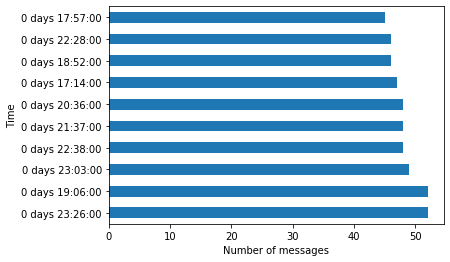

In [58]:
df_with_message['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

# The most happening day

2018-05-24    435
2018-05-18    345
2018-05-17    341
2018-05-28    321
2018-05-27    298
             ... 
2019-09-01      1
2018-10-12      1
2018-09-16      1
2020-02-03      1
2018-09-24      1
Name: Date, Length: 602, dtype: int64


Text(0, 0.5, 'Date')

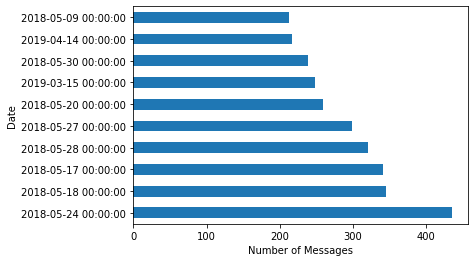

In [59]:
df_with_message['Date'].value_counts().head(10).plot.barh()
print(df_with_message['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')


# Word Cloud

In [61]:
text = " ".join(review for review in df_with_message.Message)
print (f"There are {len(text)} words in all the messages.")

There are 621186 words in all the messages.


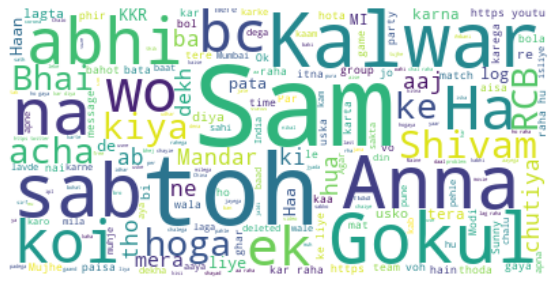

In [66]:
stopwords = set(STOPWORDS)
stopwords.update([
    'hai', 'kal', 'ka', 'se', 'ye', 'hi', 'kya', 'aur', 'bhi', 'nahi', 'nhi', 'mein', 'tu', 'mai', 'ko', 'tha',
    'kuch', 'pe', 'fir', "ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","haa","Haa","le"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author name Rahul Kalwar


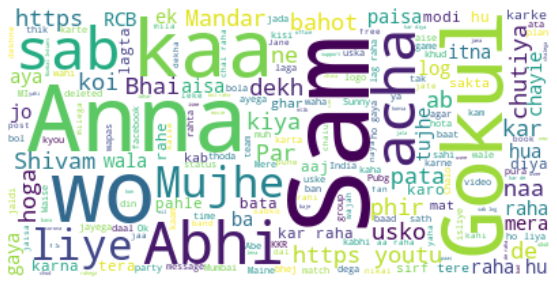

Author name Shivam Ghodke


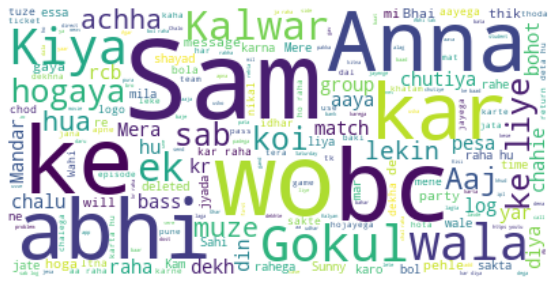

Author name Sam


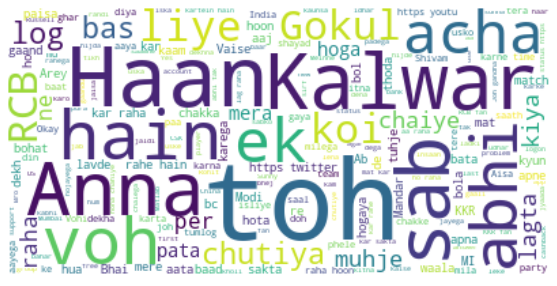

Author name Mandar


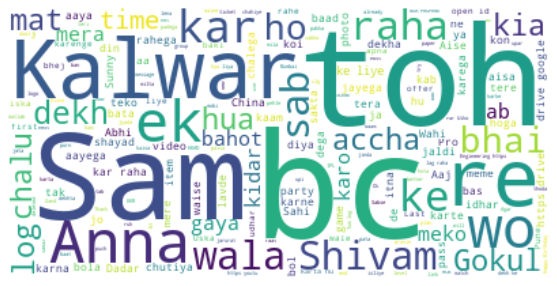

Author name Gokul


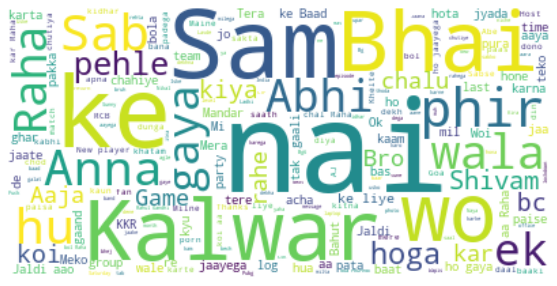

Author name Sunny


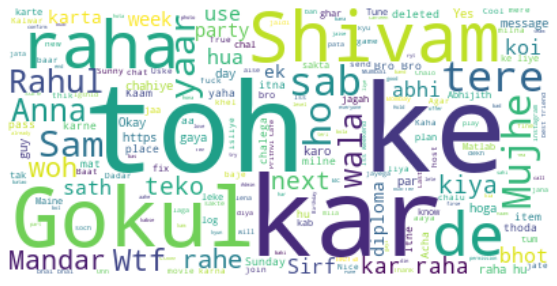

Author name Chowkidar Abhijith


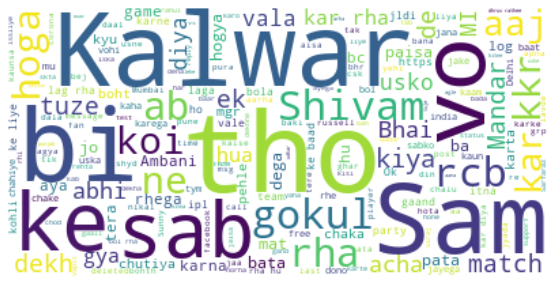

Author name Ashish Waghule


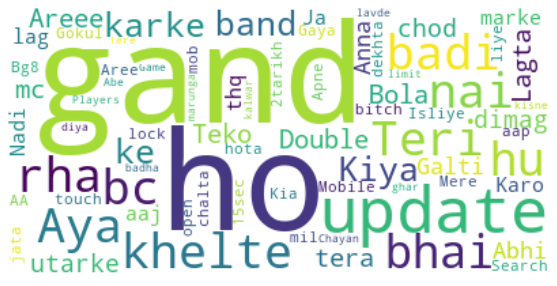

In [67]:
l = df_with_message.Author.unique()
for i in range(len(l)):
    df_temp = df_with_message[df_with_message['Author'] == l[i]]
    text = " ".join(review for review in df_temp.Message)
    stopwords = set(STOPWORDS)
    stopwords.update([
    'hai', 'kal', 'ka', 'se', 'ye', 'hi', 'kya', 'aur', 'bhi', 'nahi', 'nhi', 'mein', 'tu', 'mai', 'ko', 'tha',
    'kuch', 'pe', 'fir', "ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","haa","Haa","le"])
    
    # Generate a word cloud image
    print('Author name',l[i])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    # Display the generated image:
    # the matplotlib way:

    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()